# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
# import sklearn.linear_model as sklin
# import sklearn.metrics as skmet
# import sklearn.model_selection as skmod
# import sklearn.preprocessing as skprep
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV

In [2]:
from Functions import get_ages_cols, name_from_index, get_category_cols

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

In [4]:
gridder_source = 'load'
gridder_path = os.path.join(data_save_path, 'all_gridders3.csv')

# Get data

In [5]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)
fit_pd_all = pd.read_csv(os.path.join(data_save_path, 'fit_pd_all.csv'), index_col=0)
loadings_long_all = pd.read_csv(os.path.join(data_save_path, 'loadings_long_all.csv'), index_col=0)
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))

In [6]:
# param_cols = list(set([c for c in all_data.columns for p in get_param_names() if p in c]))
ages_cols = get_ages_cols()
category_cols = get_category_cols()

# Sources
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html -> Using `TransformedTargetRegressor` to get coefficients while doing repeated CV

## Predict age using regularized regression

### Ridge regression
* L2-norm (returns small but non-zero coefficients)
* It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high #features, say in millions, as it will pose computational challenges.
* It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

### Lasso regression
* L1-norm (sparse; tries to get many coefficients 0)
* It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.
* Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases where the #features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.

### Conclusion
* Ridge might be better because of how it deals with correlated features

## Prepare regression data in different ways (raw features, polynomial features, etc.)

In [7]:
def get_regr_data(name, all_data_z=None, fit_pd_all=None, ages=None):
    
    """
    'raw': Subset all_data_z to get the data that is used in the regression model (behavioral and parameter features).
    'pc': Subset fit_pd_all to get data (PCs based on behavioral and parameter features).
    """

    if name == 'raw':
        regr_dat = all_data_z[[c for c in all_data_z.columns if c not in ages_cols[2:] + ['age_group']]]  # behaviors
    elif name == 'pc':
        regr_dat = pd.merge(fit_pd_all, ages).drop(columns=[c for c in ages.columns if (c != 'ID') and (c != 'PreciseYrs')])  # PCs
    else:
        raise(ValueError, "name must either be 'pc' or 'raw'.")

    regr_dat = regr_dat.dropna().set_index('ID')
    regr_y = regr_dat['PreciseYrs']
    regr_X = regr_dat.drop(columns='PreciseYrs')
    
    return regr_dat, regr_X, regr_y

# Use
regr_dat_raw, regr_X_raw, regr_y_raw = get_regr_data('raw', all_data_z=all_data_z)
regr_dat_pc, regr_X_pc, regr_y_pc = get_regr_data('pc', fit_pd_all=fit_pd_all, ages=ages)

In [8]:
def get_poly_regr_task(regr_X, task_name, poly_degree=2):
    
    """
    Take data of one task and add all interactions and squared features.
    """
    
    task_cols = [c for c in regr_X.columns if task_name in c]
    poly = PolynomialFeatures(poly_degree, include_bias=False)
    regr_poly_task = poly.fit_transform(regr_X[task_cols])
    regr_poly_task = pd.DataFrame(regr_poly_task, columns=poly.get_feature_names(task_cols))
    regr_poly_task['sid'] = regr_X.index
    
    return regr_poly_task

# Example use
get_poly_regr_task(regr_X_raw, '_')  # to get ALL polynomial features
get_poly_regr_task(regr_X_raw, 'ps_')  # to polynomial features of probswitch only

,ps_ACC,ps_RT,ps_RTsd,ps_ACC_delta,ps_RT_delta,ps_miss,ps_WS,ps_LS,ps_stay,ps_alpha,...,ps_n_switches ps_WLS,ps_n_switches ps_LWS,ps_n_switches ps_criterion_trial,ps_WLS^2,ps_WLS ps_LWS,ps_WLS ps_criterion_trial,ps_LWS^2,ps_LWS ps_criterion_trial,ps_criterion_trial^2,sid
0,-1.640556,1.813096,1.080294,-1.157002,1.051827,1.759205,-1.851181,1.566624,-1.775454,-0.030674,...,-1.184683,0.399935,-0.445429,2.455470,-0.828937,0.923232,0.279839,-0.311672,0.347126,17
1,1.262185,0.948509,0.552209,0.403593,0.426914,-0.309955,0.649350,-1.113753,1.015937,-1.005885,...,0.759166,-0.002226,0.343171,1.008333,-0.002957,0.455803,0.000009,-0.001337,0.206040,18
2,1.262185,-1.011315,-1.041378,-0.532764,-0.183310,-0.309955,0.731039,-1.045716,1.015937,0.793550,...,1.089254,0.188800,0.027731,2.075813,0.359801,0.052848,0.062364,0.009160,0.001345,20
3,-0.406853,0.053639,-0.069402,1.339950,-0.506852,-0.309955,-0.657673,-0.161241,-0.100758,0.457653,...,-0.176822,-0.061027,-0.197169,0.205977,0.071090,0.229678,0.024536,0.079270,0.256108,22
4,-0.414133,0.704995,0.375077,1.339950,0.162366,-0.309955,-0.550849,0.958746,-0.877945,0.771715,...,-0.690349,0.399935,-0.377835,0.833811,-0.483046,0.456353,0.279839,-0.264376,0.249766,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.579645,0.573461,0.211713,-0.220645,-0.280566,-0.309955,0.520532,-0.663665,0.770509,0.339484,...,0.520770,0.399935,-0.504574,0.474484,0.364389,-0.459728,0.279839,-0.353057,0.445431,465
243,1.289487,-1.543292,-1.064674,0.403593,0.318348,-0.309955,0.910126,-0.501423,0.643705,0.980713,...,0.541073,0.399935,-0.327139,0.512202,0.378595,-0.309683,0.279839,-0.228903,0.187238,466
244,-0.982006,0.797215,0.508480,-0.220645,1.733725,-0.309955,-0.453451,1.769952,-1.194955,-0.018620,...,0.527718,-0.206101,-0.014291,1.834640,-0.716522,-0.049683,0.279839,0.019404,0.001345,467
245,-0.168419,0.076798,-0.294763,-1.237033,0.785000,1.759205,0.282699,-0.321575,0.503139,0.383105,...,-0.022018,-0.206101,-0.745802,0.003194,0.029896,0.108182,0.279839,1.012631,3.664325,468


In [9]:
def get_poly_regr_data(regr_X, method):
    
    """
    Take data of all tasks and add squared features and feature interactions (but only within each task).
    """
    
    if method == 'within_tasks':
        
        task_names = ['bf_', 'ps_', 'rl_']
        poly_regr_dat = get_poly_regr_task(regr_X, task_names[0])

        for task_name in task_names[1:]:

            poly_regr_task = get_poly_regr_task(regr_X, task_name)
            poly_regr_dat = pd.merge(poly_regr_dat, poly_regr_task, on=['sid'])
        
    elif method == 'all':
        
        poly_regr_dat = get_poly_regr_task(regr_X, '_')
        
    else:
        
        raise ValueError('Method argument must be either "within_tasks" or "all".')

    poly_regr_dat = poly_regr_dat.set_index('sid')
    
    return poly_regr_dat

# Use
poly_X_all = get_poly_regr_data(regr_X_raw, 'all')
poly_X_within = get_poly_regr_data(regr_X_raw, 'within_tasks')
print('Number of polynomial features: {}'.format(poly_X_all.shape[1]))
for i in range(30, 700, 30):
    print(poly_X_all.columns[i-30:i])

Number of polynomial features: 2210
Index(['bf_ACC', 'bf_RT', 'bf_RTsd', 'bf_ACC_delta', 'bf_RT_delta', 'bf_miss',
       'rl_ACC', 'rl_RT', 'rl_RTsd', 'rl_ACC_delta', 'rl_RT_delta', 'rl_miss',
       'ps_ACC', 'ps_RT', 'ps_RTsd', 'ps_ACC_delta', 'ps_RT_delta', 'ps_miss',
       'bf_WS', 'bf_LS', 'bf_stay_choice', 'bf_stay_motor', 'rl_WS', 'rl_LS',
       'rl_stay_choice', 'rl_stay_motor', 'ps_WS', 'ps_LS', 'ps_stay',
       'bf_alpha'],
      dtype='object')
Index(['bf_nalpha', 'bf_1_over_beta', 'bf_forget', 'rl_log_alpha',
       'rl_log_nalpha', 'rl_forget', 'rl_rho', 'rl_epsilon_1_over_beta',
       'rl_K', 'ps_alpha', 'ps_nalpha', 'ps_1_over_beta_rl', 'ps_persev_rl',
       'ps_1_over_beta_bf', 'ps_persev_bf', 'ps_p_switch', 'ps_p_reward',
       'rl_ACC_ns2_minus_ns5', 'rl_ACC_ns2_minus_ns5_delta',
       'rl_RT_ns5_minus_ns2', 'rl_ns_slope', 'rl_lrn-ns_sig',
       'rl_lrn-delay_sig', 'rl_lrn-pcor_sig', 'rl_lrn-pinc_sig',
       'ps_n_switches', 'ps_WLS', 'ps_LWS', 'ps_criterion

## Run repeated k-fold regression

In [10]:
class RepeatableGridSearchCV:
    
    """ Wrapper class for GridSearchCV with RepeatedKFold.
    """
    
    def __init__(
        self,
        model,
        parameters,
        n_splits=20,
        n_repeats=10,
        random_state=None,
        n_jobs=-1,
        scoring=None,
        refit=True,
    ):
        
        # cv or repeated cv?
        if n_repeats == 1:
            cv = n_splits
        else:
            cv = RepeatedKFold(
                n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
            )
        
        # setup the grid search; done
        gridder = GridSearchCV(
            model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit=refit
        )
        self._gridder = gridder
    
    def __getattr__(self, attr):
        
        """ Expose all attributes from GridSearchCV """
        
        return getattr(self._gridder, attr)

In [11]:
def make_gridder_pd(gridder):
    
    gridder_results = {
        name: gridder.cv_results_[name]
        for name in ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_alpha']
    }
    gridder_results = pd.DataFrame(gridder_results)
    
    return gridder_results

# # Example use
# make_gridder_pd(gridder)

In [12]:
model = Ridge()
n_repeats = 100
n_splitss = np.append(np.arange(2, 8), np.arange(9, 20, 2))
scoring = 'r2'  # 'r2', 'neg_mean_squared_error'
param_grid = {'alpha': [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000]}

In [13]:
if gridder_source == 'make':
    
    all_gridders = pd.DataFrame()
    for model_name in ['poly_all', 'poly_within', 'raw']:
        print("Model {}".format(model_name))

        for i, n_splits in enumerate(n_splitss):
            print("{}/{} splits".format(i, len(n_splitss)), end='\r')

            gridder = RepeatableGridSearchCV(model, param_grid, n_repeats=n_repeats, n_splits=n_splits, scoring=scoring)
            if model_name == 'poly_within':
                gridder.fit(poly_X_within, regr_y_raw)
            elif model_name == 'raw':
                gridder.fit(regr_X_raw, regr_y_raw)
            elif model_name == 'poly_all':
                gridder.fit(poly_X_all, regr_y_raw)
            else:
                raise ValueError('Argument model_name must be "poly_all", "poly_within", or "raw".')
            # sorted(gridder.cv_results_.keys())

            gridder_results = make_gridder_pd(gridder)
            gridder_results['model_name'] = model_name
            gridder_results['n_splits'] = n_splits
            all_gridders = all_gridders.append(gridder_results)
    
    # Save as csv
    all_gridders.to_csv(gridder_path)

elif gridder_source == 'load':
    
    # Load csv
    all_gridders = pd.read_csv(gridder_path, index_col=0)    

In [14]:
def make_gridder_long(gridder_results):
    
    gridder_long = pd.melt(gridder_results, id_vars=['param_alpha', 'model_name', 'n_splits'], var_name='score_name', value_name='score')
    gridder_long['stat'] = gridder_long['score_name'].apply(lambda x: x.split('_')[0])
    gridder_long['train_test'] = gridder_long['score_name'].apply(lambda x: x.split('_')[1])
    
    return gridder_long

# # Example use
# make_gridder_long(all_gridders)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 12 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_RepeatGridSearchCV.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


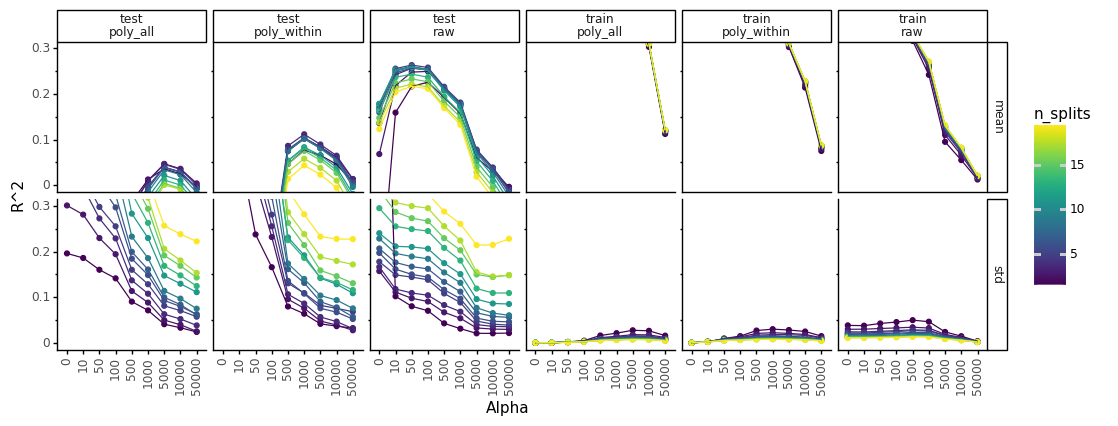

<ggplot: (132079616709)>

In [15]:
def plot_gridder(all_gridders):
    
    # Get data
    gridder_long = make_gridder_long(all_gridders)

    # Plot
    gg.options.figure_size = (12, 4)
    g = (gg.ggplot(
        gridder_long,
        gg.aes('factor(param_alpha)', 'score', color='n_splits', group='n_splits'))
         + gg.geom_point()
         + gg.geom_line()
         + gg.coord_cartesian(ylim=(0, 0.3))
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.labs(x='Alpha', y='R^2')
         + gg.facet_grid('stat ~ train_test + model_name')
        )
    gg.options.figure_size = (5, 5)
    g.save(os.path.join(plot_save_path, '5_RepeatGridSearchCV.png'))
    return g

# Example use
plot_gridder(all_gridders)

In [16]:
best_scores = all_gridders.groupby(['model_name']).aggregate('max').reset_index()[['model_name', 'mean_test_score']]
best_models = all_gridders.loc[all_gridders.mean_test_score.isin(best_scores.mean_test_score.values)]
best_models = best_models[
    ['model_name', 'param_alpha', 'n_splits', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
].reset_index(drop=True)
best_models

,model_name,param_alpha,n_splits,mean_test_score,std_test_score,mean_train_score,std_train_score
0,poly_all,5000,3,0.047018,0.049817,0.421993,0.017880
1,poly_within,1000,4,0.111923,0.086080,0.548134,0.018124
2,raw,50,5,0.263691,0.144130,0.505046,0.023122


## Plot predicted ages and fitted coefficients

In [17]:
def get_poly_task(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        p0, p1 = pred.split(' ')
        task = p0[:2] + '_' + p1[:2]

    elif '^2' in pred:
        task = pred[:2] + '^2'

    else:  # Just one task
        task = pred[:2]
    
    return task

# # Example use
# get_poly_task(lin_reg_result_raw_poly['predictor'][5])

In [18]:
def get_poly_pure_int_2(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        pure_int_2 = 'interaction'

    elif '^2' in pred:
        pure_int_2 = '^2'

    else:  # Just one task
        pure_int_2 = 'pure'
        
    return pure_int_2

# # Example use
# get_poly_pure_int_2(lin_reg_result_raw_poly['predictor'][5])

In [19]:
def plot_true_predicted(true_pred, suf=''):
    
    g = (gg.ggplot(true_pred, gg.aes('true', 'pred'))
         + gg.geom_point()
         + gg.geom_smooth()
         + gg.labs(x='True age', y='Predicted age', title=suf)
        )
    g.save(os.path.join(plot_save_path, '5_TruePredictedAge_{}.png'.format(suf)))
    return g

# # Example use
# plot_true_predicted(true_pred)

In [20]:
def beautify_coefs(coefs, name):
    
    if name == 'pc':
        coefs['predictor_cat'] = coefs['predictor'].apply(lambda x : int(x[2:]))

    else:
        # Sort predictors by coefficient value
        coefs = coefs.sort_values(by='coef')
        coefs = coefs.reset_index(drop=True)
        coefs['predictor_cat'] = pd.Categorical(coefs['predictor'], categories=coefs['predictor'])

    # Add info in extra columns
    coefs['category'] = coefs['predictor'].apply(name_from_index, names=category_cols)
    coefs['task'] = coefs.predictor.apply(lambda x : x[:2])
    pc0 = loadings_long_all.loc[loadings_long_all.PC == 0, ['index', 'pc<0>']]
    coefs = pd.merge(pc0, coefs, left_on='index', right_on='predictor', how='outer').drop(['index'], axis=1)  # add pc<0> column

    if 'poly' in name:
        coefs['poly_task'] = coefs['predictor'].apply(get_poly_task)
        coefs['pure_int_2'] = coefs['predictor'].apply(get_poly_pure_int_2)
    
    return coefs

# # Example use
# beautify_coefs(coefs, 'raw')

In [21]:
def plot_coefs(coefs, suf=''):
    
    gg.options.figure_size = (15, 5)
    
    # Plot 1
    g = (gg.ggplot(coefs, gg.aes('predictor_cat', 'coef', fill='task'))
     + gg.geom_point()
     + gg.geom_bar(stat='identity')
     + gg.labs(x='', fill='')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
    )
    g.save(os.path.join(plot_save_path, '5_PredictAgeRidge_{}.png'.format(suf)))

    # Plot 2
    g2 = g + gg.aes(fill='category') + gg.facet_grid('~ task', scales='free_x')
    g2.save(os.path.join(plot_save_path, '5_PredictAgeRidge_ByTask_{}.png'.format(suf)))

    # Plot 3
    g3 = g + gg.aes(fill='pc<0>') + gg.facet_grid('~ task', scales='free_x')
    g3.save(os.path.join(plot_save_path, '5_PredictAgeRidge_PC0_{}.png'.format(suf)))

    gg.options.figure_size = (5, 5)

    return g3
    
# # Plot coefficients of ridge regression
# plot_coefs(coefs_raw, 'raw2')

In [22]:
regr_X_raw.shape, poly_X_within.shape, poly_X_all.shape

((247, 65), (247, 806), (247, 2210))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_TruePredictedAge_poly_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


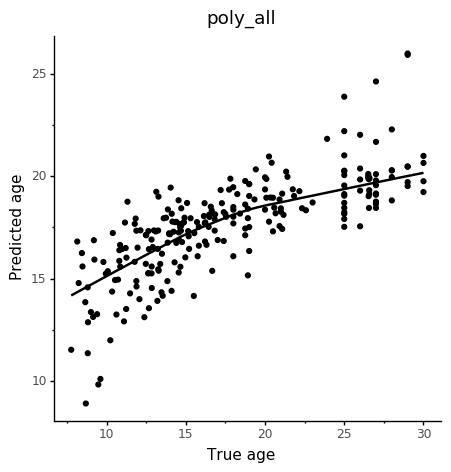

<ggplot: (-9223371904773454297)>
yay


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_poly_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_ByTask_poly_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)

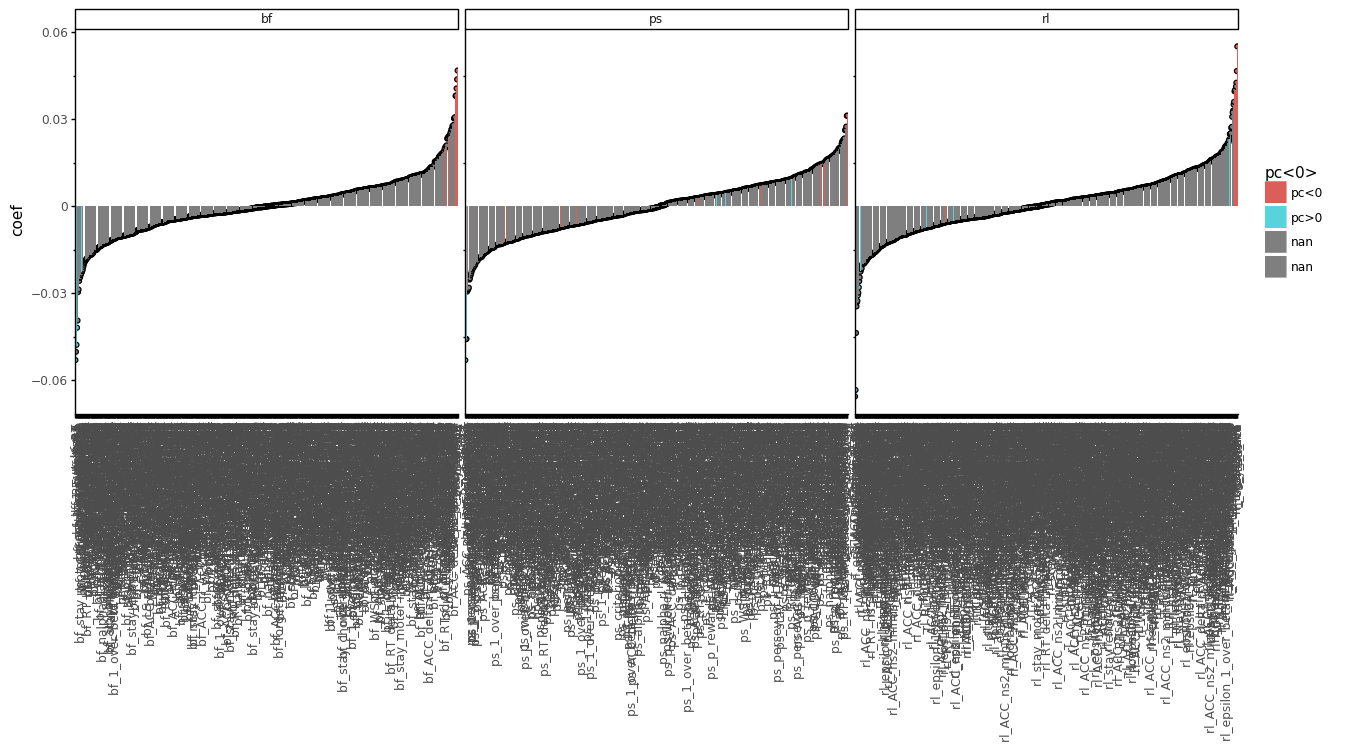

<ggplot: (-9223371904764504439)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_poly_all_sub.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_ByTask_poly_all_sub.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), Plotnine

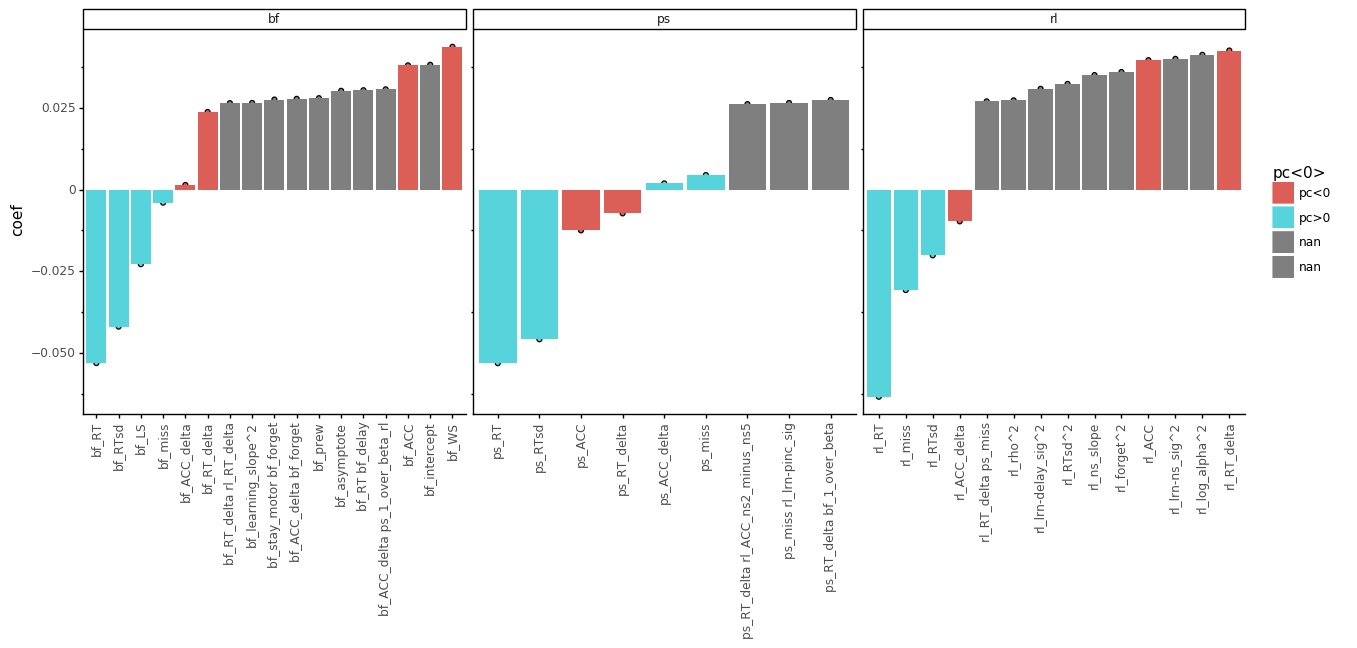

<ggplot: (132098040296)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_TruePredictedAge_poly_within.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


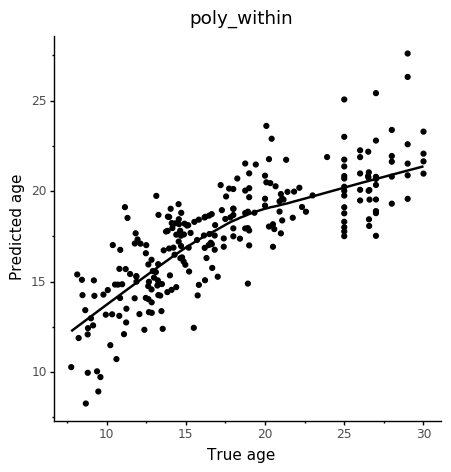

<ggplot: (-9223371904755829423)>
yay


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_poly_within.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 15 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\5_PredictAgeRidge_ByTask_poly_within.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [ ]:
for model_name in best_models.model_name:
    
    # Get data
    if model_name == 'raw':
        X, y = regr_X_raw.copy(), regr_y_raw.copy()
    elif model_name == 'poly_all':
        X, y = poly_X_all.copy(), regr_y_raw.copy()
    elif model_name == 'poly_within':
        X, y = poly_X_within.copy(), regr_y_raw.copy()
    
    # Fit model
    model_specs = best_models.loc[best_models.model_name == model_name]
    model = TransformedTargetRegressor(  # https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
            regressor=RidgeCV(
                alphas=[model_specs.param_alpha.values[0]],
                cv=RepeatedKFold(n_splits=model_specs.n_splits.values[0], n_repeats=n_repeats)),
    )
    _ = model.fit(X, y)
    
    # Get predictions
    y_pred = model.predict(X)
    true_pred = pd.DataFrame({'true': y, 'pred': y_pred})
    print(plot_true_predicted(true_pred, model_name))
    
    # Get coefficients
    coefs = pd.DataFrame(
        model.regressor_.coef_, columns=['coef'], index=X.columns
    ).reset_index().rename(columns={'index': 'predictor'})
    coefs = beautify_coefs(coefs, model_name)
    
    print('yay')
    
    print(plot_coefs(coefs, model_name))
    sub_dat = pd.concat([coefs.head(20), coefs.tail(20)])
    print(plot_coefs(sub_dat, model_name + '_sub'))

## Old stuff

In [ ]:
# model = TransformedTargetRegressor(
#         regressor=RidgeCV(alphas=[50], cv=RepeatedKFold(n_splits=6, n_repeats=n_repeats)),
# )
# _ = model.fit(regr_X_raw, regr_y_raw)

In [ ]:
# y_pred = model.predict(regr_X_raw)
# true_pred = pd.DataFrame({'true': regr_y_raw, 'pred': y_pred})

In [ ]:
# coefs = pd.DataFrame(
#     model.regressor_.coef_, columns=['coef'], index=regr_X_raw.columns
# ).reset_index().rename(columns={'index': 'predictor'})
# coefs

In [ ]:
# gg.options.figure_size = (10, 5)
# g = (gg.ggplot(coefs, gg.aes('predictor', 'coef'))
#      + gg.geom_bar(stat='identity')
#      + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#     )
# gg.options.figure_size = (5, 5)
# g

In [ ]:
# def plot_true_predicted(reg, regr_X, regr_y, name):
    
#     # Make DataFrame with true and predicted values
#     pred_y = reg.predict(regr_X)
#     linregr_true_pred = pd.DataFrame(np.array([np.array(regr_y), pred_y]).T, columns=('true_y', 'pred_y'))
    
#     # Calculate R^2
#     r2 = skmet.r2_score(regr_y, pred_y)

#     # Plot true against predicted
#     gg.options.figure_size = (6, 6)
#     g = (gg.ggplot(linregr_true_pred, gg.aes('true_y', 'pred_y'))
#          + gg.geom_point()
#          + gg.geom_smooth()
#          + gg.labs(x='True age', y='Predicted age')
#          + gg.geom_text(gg.aes(x=5, y=5, label=round(r2, 2)))
#     )
#     g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegrPerf_{}.png'.format(name)))
#     print(g)
    
# # Plot ridge regression results on testing data
# plot_true_predicted(reg_raw, regr_X_raw_test, regr_y_raw_test, 'raw')
# plot_true_predicted(reg_raw_poly, poly_X_raw_test, regr_y_raw_test, 'raw_poly')
# plot_true_predicted(reg_pc, regr_X_pc_test, regr_y_pc_test, 'pc')

In [ ]:
# best_alpha = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'alpha']

# g = (gg.ggplot(gridder_results, gg.aes('alpha', 'mean_test_score'))
#      + gg.geom_point()
#      + gg.geom_line()
#      + gg.geom_vline(xintercept=best_alpha, linetype='dotted')
#      + gg.geom_text(label=best_alpha)
#     )
# print(g)
# print("Best alpha: {}".format(best_alpha.values[0]))

In [ ]:
# def make_gridder_long(gridder_results):
    
#     gridder_long = pd.melt(gridder_results, id_vars='param_alpha', var_name='score_name', value_name='score')
#     gridder_long['stat'] = gridder_long['score_name'].apply(lambda x: x.split('_')[0])
#     gridder_long['train_test'] = gridder_long['score_name'].apply(lambda x: x.split('_')[1])
    
#     return gridder_long

# # Example use
# make_gridder_long(gridder_results)

In [ ]:
# def plot_gridder(gridder_results, n_splits, suf=''):
    
#     # Get best alpha and std at best alpha
#     gridder_long = make_gridder_long(gridder_results)
#     best_alpha = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'param_alpha']
#     best_score = gridder_results.loc[gridder_results.mean_test_score == np.max(gridder_results.mean_test_score), 'mean_test_score']
#     std_best_alpha = gridder_results.loc[gridder_results.param_alpha == best_alpha.values[0], 'std_test_score']

#     # Plot
#     g = (gg.ggplot(gridder_long, gg.aes('param_alpha', 'score', color='train_test', group='train_test'))
#          + gg.geom_point()
#          + gg.geom_line()
#          + gg.geom_vline(xintercept=best_alpha.values[0], linetype='dotted')
#          + gg.geom_text(gg.aes(y=0.2), label=std_best_alpha.round(2))
#          + gg.geom_text(gg.aes(y=0.3), label=best_alpha)
#          + gg.geom_text(gg.aes(y=0.4), label=best_score.round(4))
#          + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#          + gg.facet_wrap('~ stat')
#         )
#     g.save(os.path.join(plot_save_path, '5_RepeatGridSearchCV_nsplits{}{}.png'.format(n_splits, suf)))
    
#     return g

# # Example use
# plot_gridder(gridder_results, n_splits)

In [ ]:
def get_poly_task(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        p0, p1 = pred.split(' ')
        task = p0[:2] + '_' + p1[:2]

    elif '^2' in pred:
        task = pred[:2] + '^2'

    else:  # Just one task
        task = pred[:2]
    
    return task

# # Example use
# get_poly_task(lin_reg_result_raw_poly['predictor'][5])

In [ ]:
def get_poly_pure_int_2(pred):
    
    if ' ' in pred:  # Interaction between two tasks
        pure_int_2 = 'interaction'

    elif '^2' in pred:
        pure_int_2 = '^2'

    else:  # Just one task
        pure_int_2 = 'pure'
        
    return pure_int_2

# # Example use
# get_poly_pure_int_2(lin_reg_result_raw_poly['predictor'][5])

In [ ]:
def beautify_lin_reg_result(lin_reg_result, name):
    
    if 'raw' in name:

        # Sort predictors by coefficient value (for plotting)
        lin_reg_result = lin_reg_result.sort_values(by='coef')
        lin_reg_result = lin_reg_result.reset_index(drop=True)
        lin_reg_result['predictor_cat'] = pd.Categorical(lin_reg_result['predictor'], categories=lin_reg_result['predictor'])

    elif name == 'pc':

        # Add columns
        lin_reg_result['predictor_cat'] = lin_reg_result['predictor'].apply(lambda x : int(x[2:]))

    if 'poly' not in name:
        lin_reg_result['task'] = lin_reg_result.predictor.apply(lambda x : x[:2])
        lin_reg_result['category'] = lin_reg_result['predictor'].apply(name_from_index, names=category_cols)
    else:
        lin_reg_result['category'] = lin_reg_result['predictor'].apply(get_poly_task)
        lin_reg_result['task'] = lin_reg_result['predictor'].apply(get_poly_pure_int_2)

    
    return lin_reg_result

# # Example use
# beautify_lin_reg_result(lin_reg_result_raw, 'raw')

In [ ]:
def gridsearch_best_alpha(regr_X, regr_y):
    
    tuned_parameters = [{
        'alpha': [0, 0.2, 0.5, 1, 2, 5, 10, 50, 100, 150, 180, 200, 230, 280, 300, 400, 500, 1000, 2000, 5000, 10000, 20000],
        'max_iter': [1e5]
    }]

    # Perform grid search
    ridge_grid = skmod.GridSearchCV(
        sklin.Ridge(), tuned_parameters,
        scoring=['r2', 'neg_mean_squared_error'], cv=5,
        iid=False, return_train_score=False, refit=False
    )
    ridge_best = ridge_grid.fit(regr_X, regr_y)
    
    # Get best alpha
    gridserach_results = pd.DataFrame(ridge_best.cv_results_).sort_values(by='rank_test_r2')
    best_gridsearch_alpha = gridserach_results.loc[gridserach_results['rank_test_r2'] == 1, 'param_alpha'].values[0]
    
    return gridserach_results, best_gridsearch_alpha

# Use
gridserach_results_raw, best_gridsearch_alpha_raw = gridsearch_best_alpha(regr_X_raw, regr_y_raw)
gridserach_results_pc, best_gridsearch_alpha_pc = gridsearch_best_alpha(regr_X_pc, regr_y_pc)
gridserach_results_raw_poly, best_gridsearch_alpha_raw_poly = gridsearch_best_alpha(poly_X_raw, regr_y_raw)
print("Best alpha (raw): {}; best alpha (PCs): {}; best alpha (raw poly): {}".format(
    best_gridsearch_alpha_raw, best_gridsearch_alpha_pc, best_gridsearch_alpha_raw_poly))

In [ ]:
# Split in train and test
regr_X_raw_train, regr_X_raw_test, regr_y_raw_train, regr_y_raw_test = skmod.train_test_split(
    regr_X_raw, regr_y_raw, test_size=0.33)

regr_X_pc_train, regr_X_pc_test, regr_y_pc_train, regr_y_pc_test = skmod.train_test_split(
    regr_X_pc, regr_y_pc, test_size=0.33)

poly_X_raw_train, poly_X_raw_test, poly_y_raw_train, poly_y_raw_test = skmod.train_test_split(
    poly_X_raw, regr_y_raw, test_size=0.33)

In [ ]:
# # from sklearn import metrics
# scores = cross_val_score(
#     clf, X, y, cv=5, scoring='f1_macro')
# scores
#
# -> should do https://scikit-learn.org/stable/modules/cross_validation.html, but we don't have enough data

In [ ]:
def run_ridge_regression(best_gridsearch_alpha, regr_X, regr_y, name):
    
    reg = sklin.Ridge(alpha=best_gridsearch_alpha).fit(regr_X, regr_y)

    lin_reg_result = pd.DataFrame(
        reg.coef_, [c for c in regr_X.columns if c != 'PreciseYrs']).reset_index().rename(
        columns={'index': 'predictor', 0: 'coef'})
    lin_reg_result = beautify_lin_reg_result(lin_reg_result, name)
    
    return reg, lin_reg_result

# Run ridge regression on training data
reg_raw, lin_reg_result_raw = run_ridge_regression(best_gridsearch_alpha_raw, regr_X_raw_train, regr_y_raw_train, 'raw')
reg_raw_poly, lin_reg_result_raw_poly = run_ridge_regression(best_gridsearch_alpha_raw_poly, poly_X_raw_train, poly_y_raw_train, 'raw_poly')
reg_pc, lin_reg_result_pc = run_ridge_regression(best_gridsearch_alpha_pc, regr_X_pc_train, regr_y_pc_train, 'pc')

In [ ]:
def plot_true_predicted(reg, regr_X, regr_y, name):
    
    # Make DataFrame with true and predicted values
    pred_y = reg.predict(regr_X)
    linregr_true_pred = pd.DataFrame(np.array([np.array(regr_y), pred_y]).T, columns=('true_y', 'pred_y'))
    
    # Calculate R^2
    r2 = skmet.r2_score(regr_y, pred_y)

    # Plot true against predicted
    gg.options.figure_size = (6, 6)
    g = (gg.ggplot(linregr_true_pred, gg.aes('true_y', 'pred_y'))
         + gg.geom_point()
         + gg.geom_smooth()
         + gg.labs(x='True age', y='Predicted age')
         + gg.geom_text(gg.aes(x=5, y=5, label=round(r2, 2)))
    )
    g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegrPerf_{}.png'.format(name)))
    print(g)
    
# Plot ridge regression results on testing data
plot_true_predicted(reg_raw, regr_X_raw_test, regr_y_raw_test, 'raw')
plot_true_predicted(reg_raw_poly, poly_X_raw_test, regr_y_raw_test, 'raw_poly')
plot_true_predicted(reg_pc, regr_X_pc_test, regr_y_pc_test, 'pc')

In [ ]:
def plot_coefs(lin_reg_result, gridsearch_alpha, name):
    
    gg.options.figure_size = (18, 6)
    
    # Plot 1
    g = (gg.ggplot(lin_reg_result, gg.aes('predictor_cat', 'coef', fill='task'))
     + gg.geom_point()
     + gg.geom_bar(stat='identity')
     + gg.labs(x='', fill='')
     + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
     + gg.geom_text(gg.aes(x=2, y=0.1, label=gridsearch_alpha))
    )
    g.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegr_{}.png'.format(name)))
#     print(g)

    # Plot 2
    g2 = g + gg.aes(fill='category') + gg.facet_grid('~ task', scales='free_x')
    g2
    g2.save(os.path.join(plot_save_path, '5_PredictAgeRidgeRegr_ByTask_{}.png'.format(name)))
    
    return g2
    
# Plot coefficients of ridge regression
plot_coefs(lin_reg_result_raw, best_gridsearch_alpha_raw, 'raw')
plot_coefs(lin_reg_result_raw_poly, best_gridsearch_alpha_raw_poly, 'raw_poly')
sub_dat = lin_reg_result_raw_poly.loc[
    ((lin_reg_result_raw_poly.coef > 0.05).astype(int) + (lin_reg_result_raw_poly.coef < -0.05).astype(int)) > 0]
print(plot_coefs(sub_dat, best_gridsearch_alpha_raw_poly, 'raw_poly_sub'))
plot_coefs(lin_reg_result_pc, best_gridsearch_alpha_pc, 'pc')

# SVM

In [ ]:
all_data_z[param_cols_by_task]

In [ ]:
X, y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_param = 'bf_nalpha'  # 'bf_alpha'
print(y_param, '~', x_params)

X = all_data_z[x_params]
y = all_data_z['bf_alpha']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

svr = svm.SVR(kernel='poly', C=1e4, gamma='scale', degree=3, epsilon=.1, verbose=True)
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [ ]:
tuned_parameters = [
    {'kernel': ['rbf', 'poly'],
     'C': [1e-1, 1e1, 1e2, 1e3, 1e4],
     'gamma': [1e-5, 1e-4, 1e-4, 1e-3, 1e-2, 1e-1]}]

clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='r2', cv=2, iid=False, return_train_score=False)
clf_fit = clf.fit(X, y)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())

# clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring='explained_variance', cv=2, iid=False, return_train_score=False)
# clf_fit = clf.fit(X_train, y_train)
# print(pd.DataFrame(clf_fit.cv_results_).sort_values(by='rank_test_score').head())
clf_fit.best_params_

In [ ]:

svr = svm.SVR(C=clf_fit.best_params_['C'], gamma=clf_fit.best_params_['gamma'], kernel=clf_fit.best_params_['kernel'])
svr_fit = svr.fit(X_train, y_train)
y_train_pred = svr_fit.predict(X_train)
y_test_pred = svr_fit.predict(X_test)

print("Train score: {}".format(svr.score(X_train, y_train)))
print("Test score: {}".format(svr.score(X_test, y_test)))
print(cross_val_score(svr, X_test, y_test, cv=5))
print(cross_val_score(svr, X_test, y_test, cv=LeaveOneOut()))

plt.plot(y_train, y_train_pred, '.')
plt.plot(y_test, y_test_pred, '.')

In [ ]:
from sklearn.model_selection import GridSearchCV

# param_grid = {'polynomialfeatures__degree': np.arange(21),
#               'linearregression__fit_intercept': [True, False],
#               'linearregression__normalize': [True, False]}

# grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)



tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

clf = GridSearchCV(
    svm.SVC(), tuned_parameters, scoring=scores[0]
)
clf.fit(X_train, y_train)

In [ ]:
# import numpy as np
# from sklearn.svm import SVR
# import matplotlib.pyplot as plt
from sklearn import svm

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
# y[::5] += 3 * (0.5 - np.random.rand(8))
y += 0.5 - np.random.rand(len(X))

# #############################################################################
# Fit regression model
svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto')
svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [ ]:
# get support vectors
clf.support_vectors_

# get indices of support vectors
clf.support_

# get number of support vectors for each class
clf.n_support_

## PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)

Y_pred = pls2.predict(X)
Y_pred, Y
plt.plot(np.array(Y)[:,0], np.array(Y_pred)[:,0])

In [ ]:
x_params = [p for p in param_cols_by_task if 'bf' not in p]
y_params = [p for p in param_cols_by_task if 'bf' in p]
len(x_params)

In [ ]:
pls = PLSRegression(n_components=14)
pls.fit(all_data_z[x_params], all_data_z[y_params])

pred = pls.predict(all_data_z[x_params])
pls.score(all_data_z[x_params], all_data_z[y_params])  # R^2 of self.predict(X) wrt. y.

In [ ]:
pred = pd.DataFrame(pred, columns=y_params)
pred_l = pred.melt(var_name='param_name', value_name='param_value').reset_index()
true_l = all_data_z[y_params].melt(var_name='param_name', value_name='param_value').reset_index()
# dat = pd.merge(pred, all_data_z[y_params], left_index=True, right_index=True, suffixes=['_pred', '_true'])
# dat
dat_l = pd.merge(pred_l, true_l, on=['param_name', 'index'], suffixes=['_pred', '_true'])
dat_l

In [ ]:
(gg.ggplot(dat_l, gg.aes('param_value_pred', 'param_value_true', color='param_name'))
 + gg.geom_point(alpha=0.5)
 + gg.geom_smooth(color='black')
 + gg.facet_wrap('~ param_name')
)